# Generic biodiversity indices plotter

### Purpose
This demonstration notebook plots biodiversity indices vs time.

### Inputs
This notebook can use any of the biodiversity datasets available in the MBON Portal/Catalog:

- [BASIS data](http://dev.axiomdatascience.com/?portal_id=46) hosted by Axiom Data Science as a web service

### Outputs
Outputs are plots shown on the screen.

### Modification History
2018-01: Prototyping (L. Mehl, Axiom)  
2018-01: Plotting (W. Koeppen, Axiom)

In [3]:
!pip install tqdm

  Using cached https://files.pythonhosted.org/packages/91/55/8cb23a97301b177e9c8e3226dba45bb454411de2cbd25746763267f226c2/tqdm-4.28.1-py2.py3-none-any.whl
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.5/dist-packages/tqdm'
Consider using the `--user` option or check the permissions.

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [252]:
!pip install folium

In [2]:
# import libraries
%matplotlib inline
from IPython.core.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
from tqdm import trange
#import netCDF4
import json
import urllib
#from sklearn.cluster import KMeans

import folium
from folium.plugins import HeatMap

import sys
import glob
import os

ImportError: No module named 'tqdm'

In [254]:
# turn off certain warnings
import warnings
err = np.seterr(invalid='ignore')
warnings.filterwarnings("ignore")

## Variable Keys

The csv url is available via the 'Download' button in the [MBON Portal Catalog](http://dev.axiomdatascience.com/?portal_id=46#default-data/4).

In [255]:

## USE THESE FOR FULL DATASETS
url_fimmap_subset = 'https://data.axds.co/gs/secoora/wfs?service=WFS&version=1.1.0&request=GetFeature&outputFormat=csv&typeName=secoora:fimmap_biodiv_index&srsName=EPSG:4326&CQL_FILTER=INTERSECTS(geom%2C%20POLYGON((27.494263149134994%20-82.72773742675781%2C27.53445599440177%20-82.66113281250001%2C27.51557936585963%20-82.58972167968751%2C27.465022768090478%20-82.51693725585939%2C27.331515160144633%20-82.46887207031251%2C27.284535851914345%20-82.58834838867189%2C27.494263149134994%20-82.72773742675781)))'
url_basis = 'https://data.axds.co/gs/wfs?service=WFS&version=1.0.0&request=GetFeature&outputFormat=csv&typeName=basis:basis_fish_biodiversity_json_small'
url_marmap = 'https://data.axds.co/gs/secoora/wfs?service=WFS&version=1.0.0&request=GetFeature&outputFormat=csv&typeName=secoora:marmap_biodiv_index'
url_reef_fish_visual_census = 'https://data.axds.co/gs/mbon/ows?service=WFS&version=1.0.0&request=GetFeature&outputFormat=csv&typeName=mbon:fish_sampling_timeseries_json'
url_calcofi_fish = 'https://data.axds.co/gs/mbon/ows?service=WFS&version=1.0.0&request=GetFeature&outputFormat=csv&typeName=mbon:fish_count_json'


## FLORIDA REEF FISH POLYGON SELECTION
url = "https://data.axds.co/gs/mbon/ows?service=WFS&version=1.1.0&request=GetFeature&outputFormat=csv&typeName=mbon:fish_sampling_timeseries_json&srsName=EPSG:4326&CQL_FILTER=INTERSECTS(geom%2C%20POLYGON((25.352713536927975%20-80.26473999023439%2C25.312994123248057%20-80.09582519531251%2C25.217365923668318%20-80.14801025390626%2C25.08062377244484%20-80.21255493164064%2C24.819146481739093%20-80.53939819335939%2C24.936257323061316%20-80.67810058593751%2C25.136582259755453%20-80.45974731445314%2C25.352713536927975%20-80.26473999023439)))"
data_raw = pd.read_csv(url.replace(' ','%20'))


In [256]:
for column in data_raw.columns:
    print(column)

FID
event_id
depth_min
depth_max
sum_count
avg_length_cm
tsn
zone_name
mpa_name
habclas
time
geom


**These keys need to be modified for each dataset:**

In [257]:
sample_locid = 'event_id'
sample_sp_group = 'tsn'
sample_date = 'time'
sample_lat = 'latitude' #lat might not be available, geom is used
sample_lon = 'longitude' #lon might not be available, geom is used
sample_geom = 'geom'
sample_catch = 'sum_count'

**Check whether the date field is timestamp or epoch**

In [258]:

# if date
data_raw[sample_date] = pd.to_datetime(data_raw[sample_date])

# if this cell throws an error, the dates might be in epoch format. You can check by outputting "data_raw."

# if epoch (e.g., BASIS)
#data_raw[sample_date] = pd.to_datetime(data_raw[sample_date], unit='s')


In [259]:
# parse the geom string into longitude and latitude columns
def parse_geom(string):
    return string.replace('(', '').replace(')', '').split()

geoms = pd.DataFrame(data_raw['geom'].map(parse_geom).values.tolist(), columns=['chuck',sample_lon,sample_lat]).convert_objects(convert_numeric=True)

In [260]:
data_raw = data_raw.merge(geoms, left_index=True, right_index=True)

## Spatial distribution

In [261]:
data_subset = data_raw

In [262]:
#take the mean lat/lon to center the map
center_map = (data_subset[sample_lat].mean(), data_subset[sample_lon].mean())

# ESRI Ocean Basemap
tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Ocean_Basemap/MapServer/tile/{z}/{y}/{x}'
attr='Tiles &copy; Esri &mdash; Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri'

location_map = folium.Map(location=center_map, zoom_start=4, tiles=tiles, attr=attr)

heat_data = np.vstack((data_subset[sample_lat].values,
                       data_subset[sample_lon].values)).T.tolist()
HeatMap(heat_data, radius=7, blur=1).add_to(location_map)

location_map.add_child(folium.LatLngPopup())

display(location_map)

# Calculate Indices for Sample Data
See the BASIS Import and Calculate Indices notebook for more information: https://researchworkspace.com/file/2691846/basis-import-and-plot.ipynb

In [263]:
# select relevant coolumns, for easier on-screen reading
data_subset_clean = data_subset[
    [
        sample_locid,
        sample_date,
        sample_lat,
        sample_lon,
        sample_catch,
        sample_sp_group,
    ]
]

# convert dates from seconds before epoch to python datetime
data_subset_clean[sample_date] = pd.to_datetime(data_subset_clean[sample_date], unit='s')
#data_subset_clean

In [264]:
# create a row for each tsn, like the view in postgres
gp  = data_subset_clean.groupby([sample_locid, sample_date, sample_sp_group])

In [265]:
# apply funtions to each column to generate a grouped df
aggregated_df = gp.agg({
    sample_lat : np.unique,
    sample_lon : np.unique,
    sample_catch : np.sum, # add 'total' to label
})

#aggregated_df

In [266]:
# calculate the total count per sampleid
n =  aggregated_df.groupby([sample_locid, sample_date]).agg({
    sample_catch : np.sum, # re label to count
    }).rename(columns={sample_catch: 'n'})



In [267]:
# make tsn back into a normal colum
aggregated_df = aggregated_df.reset_index(level=[sample_sp_group])

# then merge on sampleid
aggregated_df = aggregated_df.merge(n, left_index=True, right_index=True)

aggregated_df['p_i'] = aggregated_df[sample_catch] / aggregated_df['n']



In [268]:
# create dominance and shannon-weaver diversity indices
p_i_stats = aggregated_df.groupby([sample_locid, sample_date])['p_i'].agg({'dominance' : np.max,
                                                   'sw_diversity':  lambda x: np.negative(np.sum(x * np.log(x)))})

diversity = aggregated_df.groupby([sample_locid, sample_date]).agg({
    sample_sp_group : np.count_nonzero,
    sample_lat : np.mean, # why are decimals truncated?
    sample_lon : np.mean, # why are decimals truncated?
     }).rename(columns={sample_sp_group: 'richness'})

diversity = diversity.merge(p_i_stats, left_index=True, right_index=True)

# add Pielou's Evenness Index
diversity['evenness'] = diversity['sw_diversity']/np.log(diversity['richness'])

diversity = diversity.reset_index(level=[sample_date, sample_locid])
# diversity

In [269]:
diversity.head()

event_id       time  longitude  richness  latitude  sw_diversity  \
0         4 1995-06-20  -80.39000        33  25.06733      2.860810   
1         5 1995-06-20  -80.37567        33  25.06933      3.038794   
2         6 1995-06-20  -80.37950        34  25.07250      2.691606   
3         7 1995-06-27  -80.39000        15  25.06733      1.963063   
4         8 1995-06-27  -80.37567        25  25.06933      2.613570   

   dominance  evenness  
0   0.224900  0.818191  
1   0.110345  0.869094  
2   0.197044  0.763282  
3   0.448980  0.724899  
4   0.246032  0.811951

### Histograms

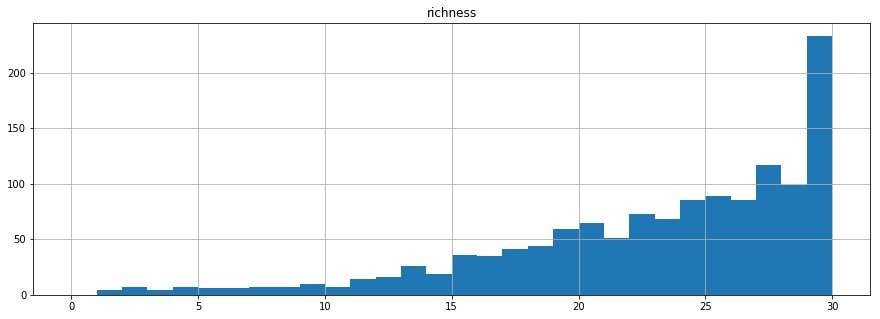

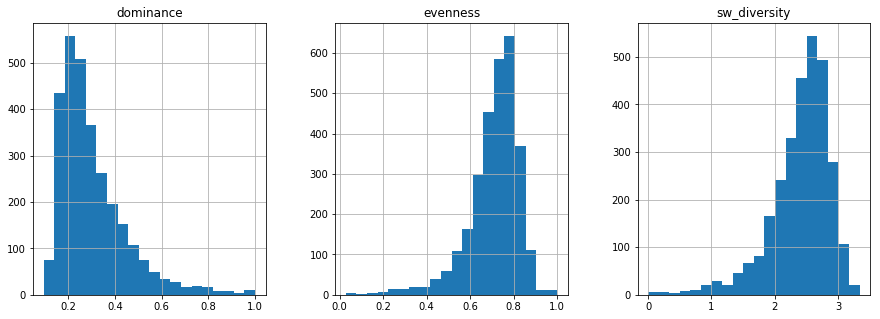

In [270]:
pd.DataFrame.hist(diversity, column=['richness'], bins=30, range=(0,30), figsize=(15,5))
pd.DataFrame.hist(diversity, column=['dominance', 'sw_diversity', 'evenness'], bins=20,
                  layout=(1, 3), figsize=(15,5))
plt.show()

### Timeseries

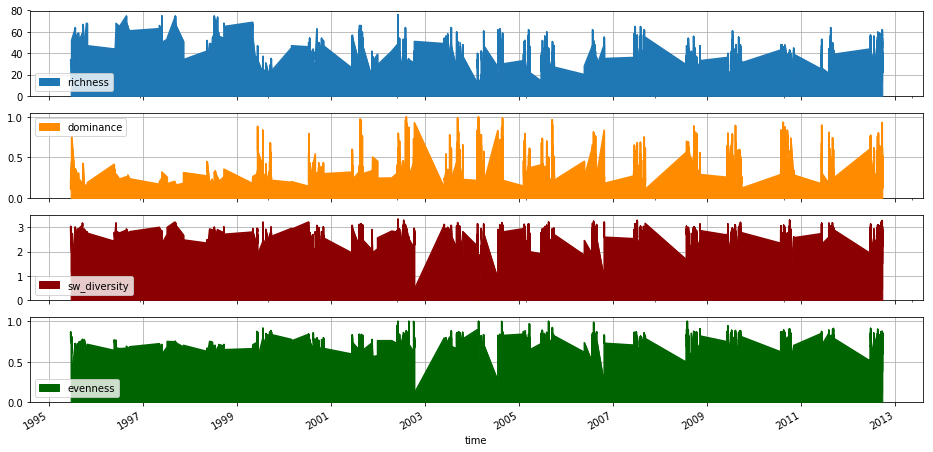

In [271]:
# super quick way to plot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16,8))

diversity.plot.area(ax=axes[0], x=sample_date, y='richness', sharex=True, grid=True, zorder=3)
diversity.plot.area(ax=axes[1], x=sample_date, y='dominance', color='darkorange', grid=True, zorder=3)
diversity.plot.area(ax=axes[2], x=sample_date, y='sw_diversity', color='darkred', grid=True, zorder=3)
diversity.plot.area(ax=axes[3], x=sample_date, y='evenness', color='darkgreen', grid=True, zorder=3)
for i in range(len(axes)):
    axes[i].grid(zorder=0)

plt.show()

Create box plots on year

In [272]:
# add year column and sort



In [273]:

# boxplot generator treats each grouping as a category rather than in a time series. so..
# dataset needs 
# create fill dates at monthly
# create new data frame with same columns as diversity and indexes incrementing up from highest index in diversity for fill_dates length
# add fill_dates to date column of new df
# merge with diversity
indices = ['dominance','evenness','richness','sw_diversity']

fill_dates = pd.date_range(start=diversity[sample_date][0], end=diversity[sample_date].iloc[-1], freq="M")
last_diversity_index = diversity.index[len(diversity.index) - 1]
fill_df = pd.DataFrame(columns=diversity.columns)
fill_df[sample_date] = fill_dates
for ind in indices:
    fill_df[ind] = 0


merged_diversity = pd.concat([diversity,fill_df])

def make_month_year(x):
    return x.strftime('%Y-%m');

merged_diversity['year'] = merged_diversity[sample_date].map(lambda x: x.year)
merged_diversity['year_month'] = merged_diversity[sample_date].map(lambda x: make_month_year(x))
merged_diversity = merged_diversity.sort_values([sample_date])



## Boxplots

In [ ]:

import seaborn


time_grouping = 'year'
include_observations = 0
tickLabels = []

w = 15
ct = 0
labels = merged_diversity[time_grouping].unique()
nth = round(len(labels)/w)

for lbl in labels:
    if (ct % nth) < 1 :
        tickLabels.append(lbl)
    else:
        tickLabels.append('')
    
    ct += 1
#include_observations = 0

tickLabels

for ind in indices:
    
    
    fig, ax = plt.subplots(figsize=(w,5))
    
    ax = seaborn.boxplot(merged_diversity[time_grouping], merged_diversity[ind], ax=ax, 
                         color="skyblue", 
                         notch="true", 
                         linewidth=.5
                        )
    
    if(include_observations):
        ax = seaborn.swarmplot(x=time_grouping, y=ind, data=merged_diversity, color=".25", size=4)
        
    plt.setp(ax, xticklabels=tickLabels)






